## Creating a Training Set for Flooding in Hurricaine Harvey
I'm adding this extra notebook to show how to use some of the data that DigitalGlobe has released covering Hurricaine Harvey in Texas.  The data is published on a website here https://www.digitalglobe.com/opendata/hurricane-harvey/post-event.  It includes satellite images before and after the flooding and vector files showing which areas flooded.  I'm going to use the "flooding analysis" shapefile, and some of the after images to create a training set.  The goal is to create training tiles with masks that show which areas flooded.

This notebook is not up to the same standards as the other notebooks, because I am writing it in a hurry to help any students who want to work with the Harvey data.  I'm hope that, despite its flaws, this notebook can show you some of the tricks I use to start working with a new geospatial dataset quickly.

This notebook does a few things to prepare a training set

1. Search a directory for tif files and get their geospatial footprints
2. use a spatial join to find out which tifs intersect with the flooding
3. Iterate through the images, and then split each one into 300x300 tiles
4. Generate a "mask" for each tile showing where the flooding is
5. Save each tile/mask pair to a directory called `training_tiles`

My apologies, but this script is REALLY slow.  I'd recommend letting it run overnight, unless you want to figure out why it's so slow.

A note about shapefiles:  Shapefiles are a format for storing geospatial vector data.  In other notebooks I save vectors as geojson.  Shapefile is an older format that stores the same type of data as geojson.  However, shapefiles are a really sloppy format so they actually consist of several different files with different extensions.  We call them "shapefiles", because you usually open the `.shp` file, but you also need to leave all the other files (like `dbf` and `shx`) in the same directory.  

In [1]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
import shapely.geometry

%matplotlib inline

# Tell the script where to look for images
path_to_harvey_images = '/home/alan/Desktop/flood'

# Load the shapefile with the flooding
flooding = gpd.read_file('/home/alan/Desktop/flood/20170831_130614_Flood_Analysis.shp')

# Convert the CRS of the flooding file
flooding.to_crs({'init': 'epsg:4326'}, inplace=True)

# Get a list of all of the tif files
tif_files = [os.path.join(path_to_harvey_images, fn) for fn in os.listdir(path_to_harvey_images) if fn.endswith('tif')]

# Get the shape of each image
geometry = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        geometry.append(shapely.geometry.box(*src.bounds))

# Create a GeoDataFrame with the image footprints
footprints = gpd.GeoDataFrame({'file_name': tif_files}, geometry=geometry, crs={'init': 'epsg:4326'})

# Filter for just the images that have flooding in them (I know I sqeezed a lot into one line)
footprints_with_flooding = footprints[footprints.index.isin(gpd.sjoin(flooding, footprints, how='inner', op='intersects').index_right.unique())]

In [2]:
def tile_image(file_name, tile_size):
    src = rasterio.open(file_name)
    
    width = src.width
    height = src.height
    
    for i in range(0, width - tile_size, tile_size):
        for j in range(0, height - tile_size, tile_size):
            window = ((j, j + tile_size), (i, i + tile_size))
            
            # Load the tile
            img = src.read(window=window).transpose([1,2,0])
            
            # Get metadata about the tile
            transform = list(np.array(~src.window_transform(window))[[0, 1, 3, 4, 2, 5]])
            box = shapely.geometry.box(*src.window_bounds(window))
            
            # Skip any image with more than 10% missing pixels
            if (img == 0).all(axis=2).sum() / img.size > 0.1:
                continue
                
            yield img, transform, box

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def get_mask(mask_poly, img_shape, transform):
    # Transform the poly into image coords
    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, transform)
    
    # Add a buffer to pad it out a little
    mask_poly_pxcoords = mask_poly_pxcoords.buffer(2)
    
    return make_mask(img_shape, mask_poly_pxcoords)

In [ ]:
# Start Iterating through tiles

os.makedirs('training_tiles')

tiles = []
tile_no = 0
for i, row in footprints_with_flooding.iterrows():
    for tile_img, tile_transform, tile_box in tile_image(row.file_name, 300):
        mask_poly = flooding[flooding.intersects(tile_box)].intersection(tile_box).unary_union
        
        # Skip tiles with no flooding (you can try keeping them)
        if mask_poly.area < 1e-12:
            continue
            
        mask = get_mask(mask_poly, tile_img.shape[:2], tile_transform)
        
        np.save("training_tiles/%d_mask"%tile_no, mask)
        np.save("training_tiles/%d_img"%tile_no, tile_img)
        tile_no += 1

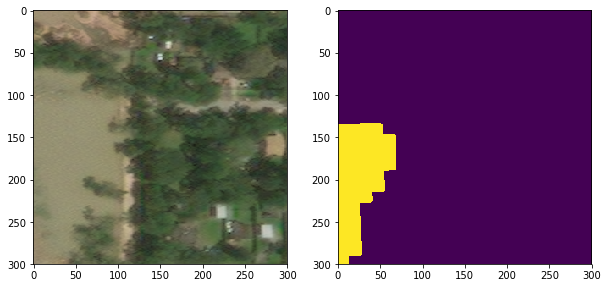

In [4]:
tile_no = 23
img = np.load('training_tiles/%d_img.npy'%tile_no)
mask = np.load('training_tiles/%d_mask.npy'%tile_no)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img)
ax2.imshow(mask)